# Using Lime with Pytorch

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

In [2]:
pip install torch torchvision lime --user

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy --upgrade --ignore-installed --user

  Using cached numpy-1.24.2-cp310-cp310-win_amd64.whl (14.8 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ithin\\AppData\\Roaming\\Python\\Python310\\site-packages\\numpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Check the permissions.



In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

Load our test image and see how it looks.

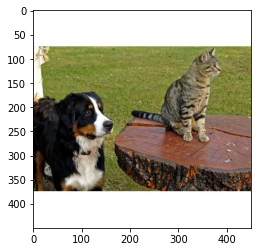

In [5]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./data/dogs.png')
plt.imshow(img)

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [6]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

Load the pretrained model for Resnet50 available in Pytorch.

In [7]:
model = models.inception_v3(pretrained=True)

C:\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load label texts for ImageNet predictions so we know what model is predicting

In [8]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

Get the predicition for our image.

In [9]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.

In [10]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.93593, 239, 'Bernese_mountain_dog'),
 (0.038447928, 241, 'EntleBucher'),
 (0.023756307, 240, 'Appenzeller'),
 (0.0018181851, 238, 'Greater_Swiss_Mountain_dog'),
 (9.113272e-06, 214, 'Gordon_setter'))

We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output. 

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [11]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [12]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's test our function for the sample image.

In [13]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

239

Import lime and create explanation for this prediciton.

In [14]:
from lime import lime_image

In [15]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's use mask on image and see the areas that are encouraging the top prediction.

In [16]:
from skimage.segmentation import mark_boundaries

In [20]:
explanation

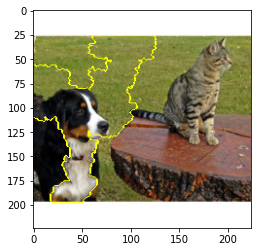

In [17]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

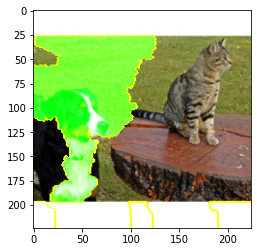

In [18]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)